In [36]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
#try:
#    os.chdir("L:\laupodteam\AIOS\Huibert-Jan\Celldynclustering\celldyn_embedder")
#except FileNotFoundError:
#    os.chdir('C:/Users/Huibert-Jan/Documents/Werk/UMCU/celldyn_embedder')    


## overhead
import sys
import os
import gc
from tqdm import tqdm

## data structures
import pandas as pd
import numpy as np

## plotting
import matplotlib.pyplot as plt
import seaborn as sns

## embedding
import umap

## model selection and tuning
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GroupKFold, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler

## models
from xgboost import XGBRegressor, XGBRFClassifier
from sklearn.linear_model import Lasso
from statsmodels.regression.linear_model import OLS

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### load imputed data

In [3]:
celldyn = pd.read_feather("T:/laupodteam/AIOS/Bram/data/CellDyn/celldyn_FULL_transformed_df.feather")
celldyn.columns = celldyn.columns.str.lower()
gc.collect()

10582

### select independent variables and age

In [4]:
meas_cols = [c for c in celldyn if ('combo' in c) or ('c_b_' in c)]

In [5]:
X = celldyn[meas_cols].to_numpy()
y = celldyn.age.to_numpy()

In [31]:
from sklearn.base import BaseEstimator
class RegrSwitcher(BaseEstimator):

    def __init__(
        self, 
        estimator = Lasso(),
    ):
        """
        A Custom BaseEstimator that can switch between classifiers.
        :param estimator: sklearn object - The classifier
        """ 

        self.estimator = estimator


    def fit(self, X, y=None, **kwargs):
        self.estimator.fit(X, y)
        return self


    def predict(self, X, y=None):
        return self.estimator.predict(X)


    # def predict_proba(self, X):
    #     return self.estimator.predict_proba(X)


    def score(self, X, y):
        return self.estimator.score(X, y)

In [42]:
parameters = [
    {
        'regr__estimator': [Lasso()],
        
    },
    {
        'regr__estimator': [XGBRegressor()],
    },
]


In [28]:
pipe = Pipeline([
    ("scaler",StandardScaler()),
    ("regr",XGBRegressor())
])


### subsampling to make it less cruesome

In [17]:
idx = np.random.randint(0,X.shape[0],size = 20000)
X_sample = X[idx,:]
y_sample = y[idx]

In [37]:
parameters = [{'regr__max_depth':[1,2,5,10],"regr__gamma":[0.01,0.1,0.2,0.4,0.6],"regr__n_estimators":[50,100,200,500]}]

folds = GroupKFold(n_splits=10)

for train,test in tqdm(folds.split(X_sample,y_sample,groups=celldyn.studyid_alle_celldyn[idx])):
    gscv = RandomizedSearchCV(pipe, parameters, cv=10, n_jobs=3, return_train_score=False, verbose=3)
    gscv.fit(X_sample[train,:],y_sample[train])
    print(gscv.score(X_sample[test,:],y_sample[test]))
    print(gscv.best_estimator_)

0it [00:00, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


In [14]:
gscv.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()), ('regr', Lasso(alpha=0.001))])

c:\Users\hjoosse3\.conda\envs\embcelldyn\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\hjoosse3\.conda\envs\embcelldyn\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

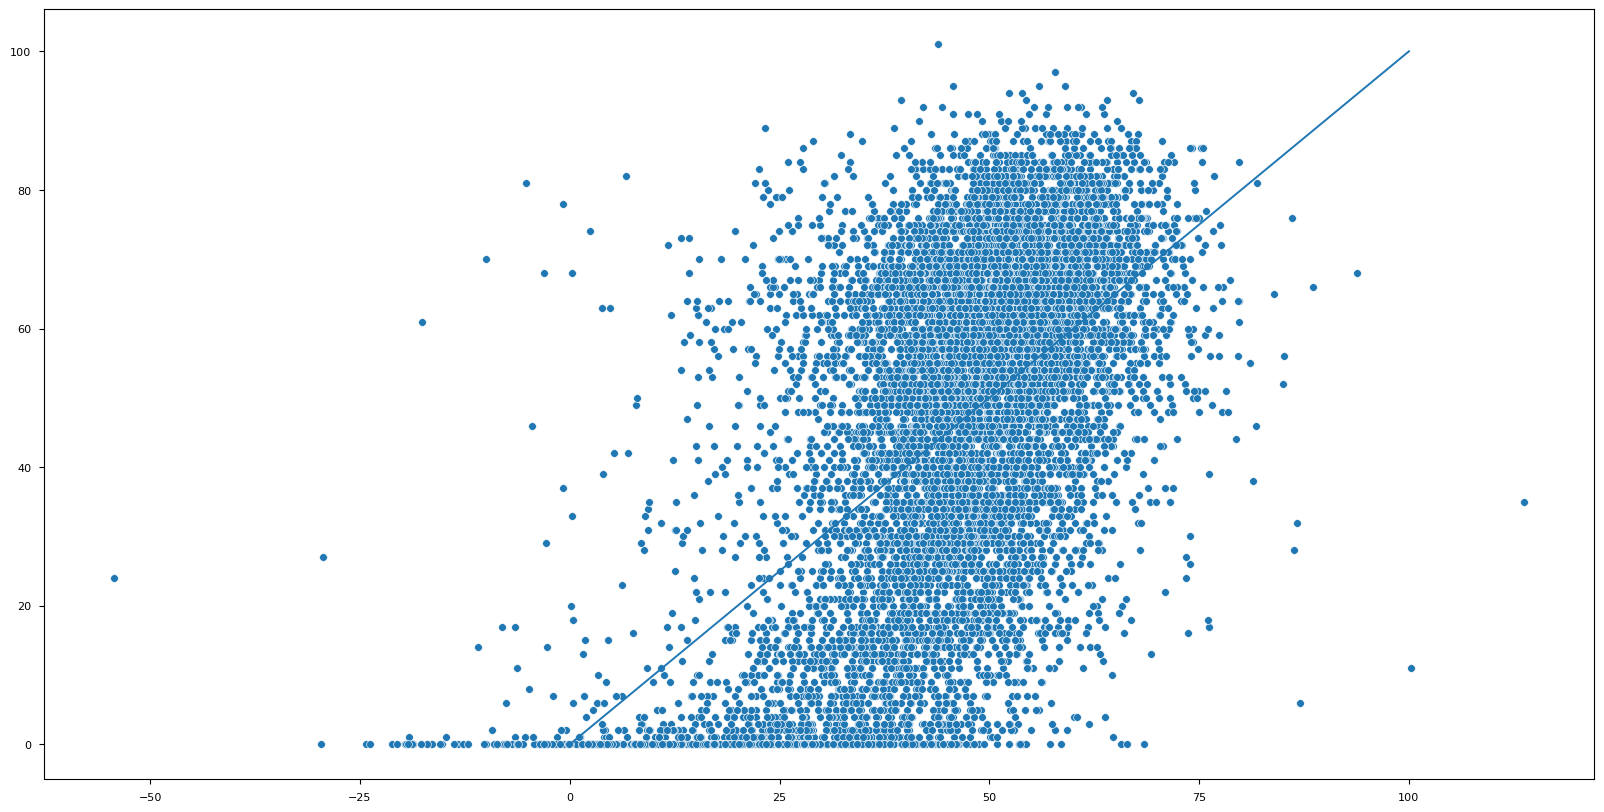

In [13]:
plt.style.use("seaborn-paper")

plt.figure(figsize = (20,10))

sns.scatterplot(y_pred[idx],y_test[idx])
sns.lineplot([0,100],[0,100])